In [154]:
#import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from scipy import stats

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import csv

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [155]:
#get data
train = pd.read_csv("input/train.csv", index_col="Id")
test = pd.read_csv("input/test.csv", index_col="Id")

# ids of full training dataset
id_train = train.index    

# ids of full test dataset
id_test = test.index

all = pd.concat([train, test], sort=True)
all.head()


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [156]:
#inspect the columns that have NAN's, clearly most of these are to represent that there is no such feature in the house
cols_with_na = all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
Exterior2nd        1
KitchenQual        1
Exterior1st        1
Electrical         1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
TotalBsmtSF        1
GarageArea         1
dtype: int64


In [157]:
#fill na's in the columns that show the existence of a feature with 'None'
cols_tonone = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

for col in cols_tonone:
    all[col].fillna('None',inplace=True)

all[cols_tonone].head()

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageQual,GarageCond,GarageFinish,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2
Id,,,,,,,,,,,,,,,
1,None,None,None,None,BrkFace,None,TA,TA,RFn,Attchd,No,TA,Gd,GLQ,Unf
2,None,None,None,None,None,TA,TA,TA,RFn,Attchd,Gd,TA,Gd,ALQ,Unf
3,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Mn,TA,Gd,GLQ,Unf
4,None,None,None,None,None,Gd,TA,TA,Unf,Detchd,No,Gd,TA,ALQ,Unf
5,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Av,TA,Gd,GLQ,Unf


In [158]:
#fill na's in the columns that show some metric of a feature that doesn't exist with 0

#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
all.loc[all.GarageYrBlt.isnull(),'GarageYrBlt'] = all.loc[all.GarageYrBlt.isnull(),'YearBuilt']

cols_tozero = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars']

for col in cols_tozero:
    all[col].fillna(0,inplace=True)

all[cols_tozero].head()

,MasVnrArea,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageArea,GarageCars
Id,,,,,,,,,
1,196.0,1.0,0.0,706.0,0.0,150.0,856.0,548.0,2.0
2,0.0,0.0,1.0,978.0,0.0,284.0,1262.0,460.0,2.0
3,162.0,1.0,0.0,486.0,0.0,434.0,920.0,608.0,2.0
4,0.0,1.0,0.0,216.0,0.0,540.0,756.0,642.0,3.0
5,350.0,1.0,0.0,655.0,0.0,490.0,1145.0,836.0,3.0


In [159]:
cols_with_na = all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))
all['LotFrontage'].head(n=10)

SalePrice      1459
LotFrontage     486
MSZoning          4
Functional        2
Utilities         2
Electrical        1
Exterior1st       1
Exterior2nd       1
KitchenQual       1
SaleType          1
dtype: int64


Id
1     65.0
2     80.0
3     68.0
4     60.0
5     84.0
6     85.0
7     75.0
8      NaN
9     51.0
10    50.0
Name: LotFrontage, dtype: float64

In [160]:
#It seems that the last column with a substantial amount of na's is LotFrontage. We will simply fill the na's with the mean of LotFrontage.

mean = all['LotFrontage'].mean()

all['LotFrontage'].fillna(mean, inplace=True)

all['LotFrontage'].head(n=10)

Id
1     65.000000
2     80.000000
3     68.000000
4     60.000000
5     84.000000
6     85.000000
7     75.000000
8     69.305795
9     51.000000
10    50.000000
Name: LotFrontage, dtype: float64

In [161]:
cols_with_na = all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))
cols_with_na = ['MSZoning', 'Functional', 'Utilities', 'Electrical', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']
all[cols_with_na].head()

SalePrice      1459
MSZoning          4
Functional        2
Utilities         2
Electrical        1
Exterior1st       1
Exterior2nd       1
KitchenQual       1
SaleType          1
dtype: int64


,MSZoning,Functional,Utilities,Electrical,Exterior1st,Exterior2nd,KitchenQual,SaleType
Id,,,,,,,,
1,RL,Typ,AllPub,SBrkr,VinylSd,VinylSd,Gd,WD
2,RL,Typ,AllPub,SBrkr,MetalSd,MetalSd,TA,WD
3,RL,Typ,AllPub,SBrkr,VinylSd,VinylSd,Gd,WD
4,RL,Typ,AllPub,SBrkr,Wd Sdng,Wd Shng,Gd,WD
5,RL,Typ,AllPub,SBrkr,VinylSd,VinylSd,Gd,WD


In [162]:
#The last remaining columns with na's are all categorical variables, so we will simply replace the na's with the respective column's mode.

for col in cols_with_na:
    all[col].fillna(all[col].mode()[0], inplace=True)

In [163]:
#Verify we have done our job correctly
cols_with_na = all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

SalePrice    1459
dtype: int64


In [164]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    all[col].replace(dict_ExGd, inplace=True)

display(all[cols_ExGd].head(5))    

# Remaining columns
all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4,3,4,3,5,4,0,3,3,0
2,3,3,4,3,5,3,3,3,3,0
3,4,3,4,3,5,4,3,3,3,0
4,3,3,3,4,4,4,4,3,3,0
5,4,3,4,3,5,4,3,3,3,0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


C:\Users\Ricky\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


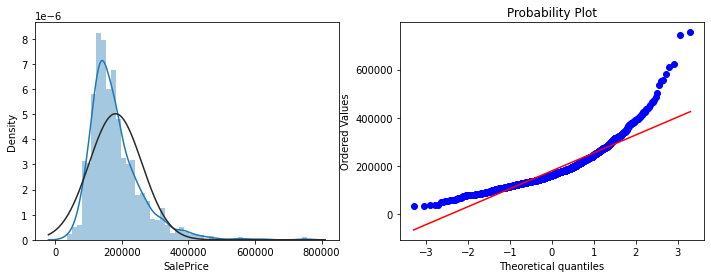

In [165]:
#inspect SalePrice

print(all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(all.SalePrice.dropna() , fit=stats.norm)
plt.subplot(1,2,2)
_=stats.probplot(all.SalePrice.dropna(), plot=plt)

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


C:\Users\Ricky\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


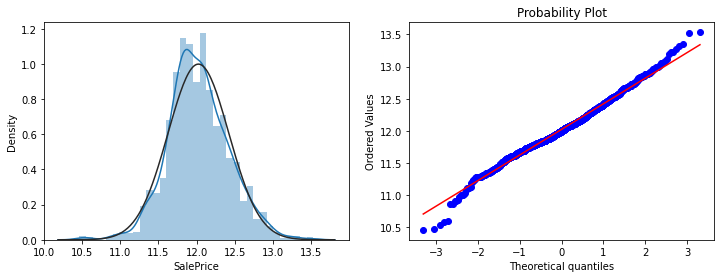

In [166]:
#SalePrice is quite skewed, so we can use log transform to combat this

sp = all.SalePrice
all.SalePrice = np.log(sp)

print(all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm)
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)

In [167]:
#Finally, lets convert all of the categorical data into numerical data.
all = pd.get_dummies(all).reset_index(drop=True)

In [168]:
# function to get training samples
def get_training_data():
    # extract training samples
    df_train = all.loc[:1459]
    
    # split SalePrice and features
    y = df_train.SalePrice
    X = df_train.drop('SalePrice',axis=1)
    
    return X, y

# extract test data (without SalePrice)
def get_test_data():
    return all.loc[id_test].drop('SalePrice',axis=1)

In [169]:
# Time to find and remove outliers!
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [170]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.9328020661514363
rmse= 0.10351269951411557
---------------------------------------
mean of residuals: -1.1278649247424878e-15
std of residuals: 0.1035481672895317
---------------------------------------
18 outliers:
[30, 88, 462, 495, 523, 588, 632, 681, 710, 728, 825, 874, 968, 970, 1298, 1324, 1432, 1453]


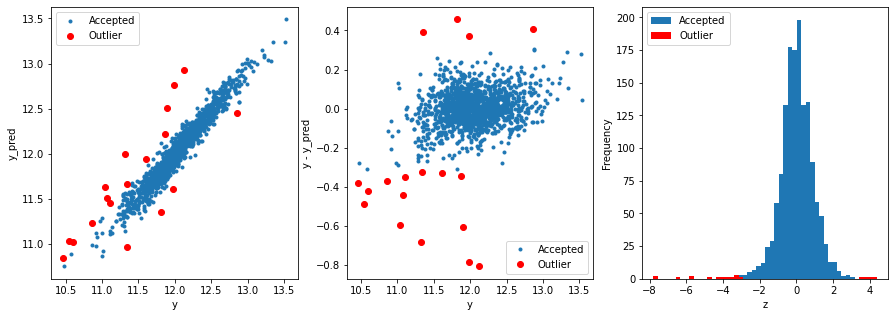

In [171]:
X_train, y = get_training_data()

outliers = find_outliers(Ridge(), X_train, y)

all = all.drop(outliers)
id_train = id_train.drop(outliers)

In [ ]:
# Time to model! This time we will be using kfolds cross validator on our models.
# We will 